In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import janitor

from scipy.stats import ttest_ind

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generalized Bayesian A/B\[/C/D/E...\] tests

## Abstract

"If you use Bayesian methods, there should be nothing stopping you from doing comparisons of more than two groups." With this pedagogical article, I hope to make the case that mastering a language that allows us to construct arbitrary models enables us to go beyond simple case/control (A/B) testing, giving us a tool to flexibly analyze data originating from complex experimental designs. 

## Introduction

### Observations on A/B Testing

Bayesian A/B testing has been gaining popularity over the years. I believe that there are two conceptual and two practical reasons for this.

#### Conceptual Reasons

Firstly, A/B tests are conceptually simple. I have a baseline (group "A"), and compare it to a perturbed setting (group "B"), and do an analysis comparing some summary statistic of both groups.

Secondly, established methods exist for doing A/B analyses, the most common being the t-test. Under certain assumptions, say, equal variance, with a t-distributed likelihood function, having carefully determined the degrees of freedom... At the risk of revealing a spoiler of this article, how often do we actually encounter these assumptions? Can we go further and do A/B\[/C/D/E\] testing? What about breaking these rigid assumptions?

#### Practical Reasons

Firstly, we have probabilistic programming languages that allow us to express the classical t-test in a Bayesian fashion. 

Secondly, we have a wealth of freely available teaching material online, enabling a new generation of data scientists to conduct Bayesian A/B tests.


### On Probabilistic Programming Languages (PPLs)

The first practical reason touched on PPLs. PPLs, such as PyMC3 (#cite), Stan (#cite) and Edward (#cite), allow us to express a statistical model in terms of (a) probability distributions describing our beliefs about a particular parameter, essentially assigning "credibility points" to parameter values and/or ranges, and (b) mathematical functions (a.k.a. transformations) that link what statisticians call "independent" or "predictor" variables to one or more "target(s)" or "output(s)". (#diagram) 

By use of simulation methods (essentially Markov Chain Monte Carlo (MCMC) sampling), PPLs provide a level of abstraction away from the difficult mathematics underlying Bayesian statistical inference. Without PPLs, Bayesian statistical analysis would often involve intractable integrals; without PPLs, in order to make these integrals tractable, we would usually have to limit ourselves to models that take advantage of distribution conjugacy, such as the Beta-Bernoulli/Binomial model, or assume Gaussian-distributed parameters and likelihoods.

### Going Beyond A/B Testing

In retrospect, the idea that one should be able go beyond A/B testing should be obvious if you know the mechanics behind doing a Bayesian A/B test. Therefore, nothing I write below should be "new knowledge". However, I do not think this point is sufficiently popularized at conferences. Here's just a sampling of titles from conferences, based on a keyword search of "A/B testing conferences" (given the personalization that happens on search engines, your replication mileage may vary):

- https://odsc.com/training/portfolio/percent-change-estimation-ab-testing
- https://odsc.com/training/portfolio/mastering-ab-testing-from-design-to-analysis
- https://github.com/datapythonista/odsc-bayesian-ab-testing-talk/blob/master/Bayesian%20AB%20testing.ipynb
- https://www.youtube.com/watch?v=8DMU9h4dwi8
- https://www.youtube.com/watch?v=PSqtcNZDj4A

## An Example of Bayesian A/B testing

This section is intended for readers who are not familiar with the mechanics of a Bayesian A/B test. Here, we will use a modified example from the Bayesian Estimation Supersedes the t-Test paper (#cite).

Let us look at a fictional scenario, where we have data measuring the effect of a drug on IQ. The dose has been set; here we are essentially doing a gold-standard, two-arm, randomized controlled trial (RCT), where one group has been given a placebo, and the other has been given a drug, and participants are randomized between the groups.

To get ourselves warmed up, let us look at the data that comes from this trial.

In [2]:
drug = [ 99.,  110.,  107.,  104.,  103.,  105.,  105.,  110.,   99.,
        109.,  100.,  102.,  104.,  104.,  100.,  104.,  101.,  104.,
        101.,  100.,  109.,  104.,  105.,  112.,   97.,  106.,  103.,
        101.,  101.,  104.,   96.,  102.,  101.,  100.,   92.,  108.,
         97.,  106.,   96.,   90.,  109.,  108.,  105.,  104.,  110.,
         92.,  100.]

placebo = [ 95.,  105.,  103.,   99.,  104.,   98.,  103.,  104.,  102.,
            91.,   97.,  101.,  100.,  113.,   98.,  102.,  100.,  105.,
            97.,   94.,  104.,   92.,   98.,  105.,  106.,  101.,  106.,
           105.,  101.,  105.,  102.,   95.,   91.,   99.,   96.,  102.,
            94.,   93.,   99.,   99.,  113.,   96.]

It usually is instructive to compare the two distributions of data. To avoid binning bias, we will plot the empirical cumulative distributions of both groups on the same plot.

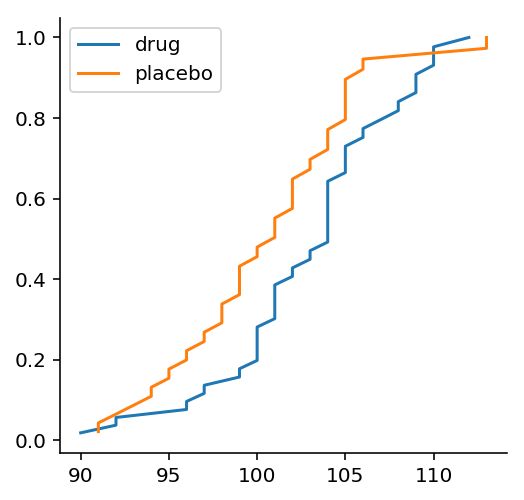

In [3]:
def ECDF(data):
    x = np.sort(data)
    y = np.cumsum(x) / np.sum(x)
    
    return x, y

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
ax.plot(*ECDF(drug), label='drug')
ax.plot(*ECDF(placebo), label='placebo')
plt.legend()
plt.show()

### Frequentist t-test

If we were to do a two-sample t-test, working with the relaxed assumption that variances are not necessarily equal between the two groups, we would get the following result:

In [4]:
ttest_ind(drug, placebo, equal_var=False)

Ttest_indResult(statistic=2.2756936448780114, pvalue=0.025378475627288653)

At the significance level of $\alpha = 0.05$, we obtained a p-value of 0.02, which means that at a "significance level" of 0.05, we reject the null hypothesis that drug treatment did not increase the IQ of participants.

If that sounded confusing, fret not because you are not alone: this author usually needs to articulate that sentence a few times to properly comprehend that we have only rejected the null hypothesis, but not accepted the "alternate" hypothesis.

### Bayesian estimation

According to Kruschke's paper, we can move beyond the t-test, and flexibly create a model that explicitly encodes our assumptions about the data. 

In [5]:
y_vals = np.concatenate([drug, placebo])
labels = ['drug'] * len(drug) + ['placebo'] * len(placebo)

data = pd.DataFrame([y_vals, labels]).T
data.columns = ['IQ', 'treatment']

In this model, we explicitly state that we are modelling the data with t-distributions, with a shared degrees of freedom nuisance parameter and separately modelled means and variances. (This also encodes the not-necessarily-equal variances assumption into the model.) Finally, we also assume that the means of both likelihoods are normally distributed, that without seeing the data, we assume a very flat prior centered on the average human IQ, and that the variances are Cauchy-distributed, but can only take positive values (i.e. positive support), as expressed by the HalfCauchy distributions used below.

Using PyMC3, a PPL that allows statistical models to be expressed using Python syntax, the aforementioned model can be implemented as follows.

In [6]:
with pm.Model() as kruschke_model:
    
    mu_drug = pm.Normal('mu_drug', mu=100, sd=100**2)
    mu_placebo = pm.Normal('mu_placebo', mu=100, sd=100**2)
    sigma_drug = pm.HalfCauchy('sigma_drug', beta=100)
    sigma_placebo = pm.HalfCauchy('sigma_placebo', beta=100)
    nu = pm.Exponential('nu', lam=1/29) + 1

    drug_like = pm.StudentT('drug', nu=nu, mu=mu_drug, 
                            sd=sigma_drug, observed=drug)
    placebo_like = pm.StudentT('placebo', nu=nu, mu=mu_placebo, 
                               sd=sigma_placebo, observed=placebo)
    diff_means = pm.Deterministic('diff_means', mu_drug - mu_placebo)
    pooled_sd = pm.Deterministic('pooled_sd', 
                                 np.sqrt(np.power(sigma_drug, 2) + 
                                         np.power(sigma_placebo, 2) / 2))
    effect_size = pm.Deterministic('effect_size', 
                                   diff_means / pooled_sd)


Using PyMC3, inference is performed by using two lines of code:

In [7]:
with kruschke_model:
    kruschke_trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, sigma_placebo, sigma_drug, mu_placebo, mu_drug]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:07<00:00, 673.56draws/s]


As is good practice in Bayesian statistical modelling, before arriving at conclusions, we use visual diagnostics to check that sampling has converged.

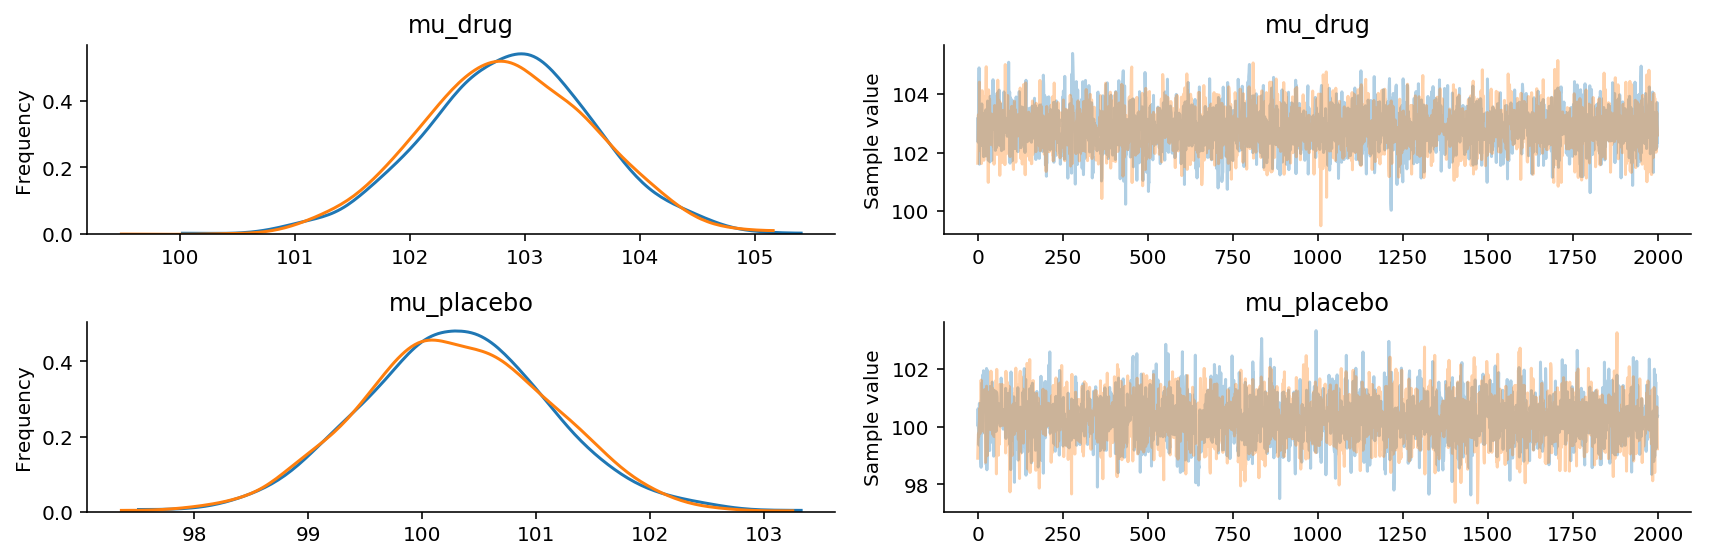

In [8]:
pm.traceplot(kruschke_trace, varnames=['mu_drug', 'mu_placebo'])
plt.show()

The visual diagnostic for a good sampling run is a "hairy caterpillar" type of MCMC trace, as shown on the right hand side panels.

Non-hairy-caterpillar MCMC sampling runs is usually an indication of mathematical issues in the model, in which case a reparameterization or respecification of priors might be in order. Fixing these issues, however, is not a central focus of this article, hence the examples in this article will not show those issues.

We should compare the two posterior distributions on the same x-axis scale, in order to see the effect.

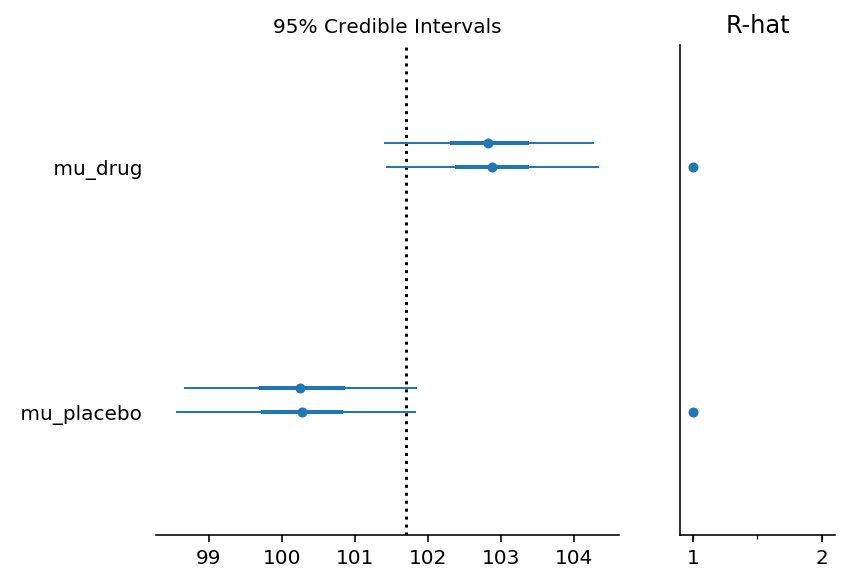

In [9]:
pm.forestplot(kruschke_trace, varnames=['mu_drug', 'mu_placebo'], vline=101.7)
plt.show()

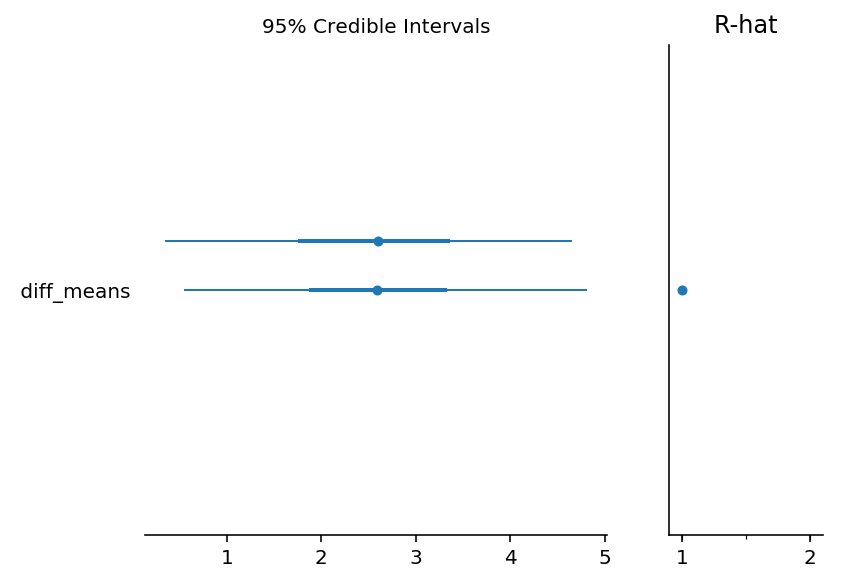

In [10]:
pm.forestplot(kruschke_trace, varnames=['diff_means'], vline=0)
plt.show()

Looking at the difference in means, we can see that the posterior distribution is centered at approximately 2.5 IQ units, with the 95% highest posterior density ranging from approximately 0.5 to 4.5 IQ units, and that the posterior does not overlap with a difference in 0 IQ units. Hence we might be tempted to conclude that the drug does indeed increase IQ!

While that statement is true under the data provided and the model that we have specified, looking at the two posterior means is generally not enough, though. What we are really interested in is whether there is a large enough effect size to justify the treatment.

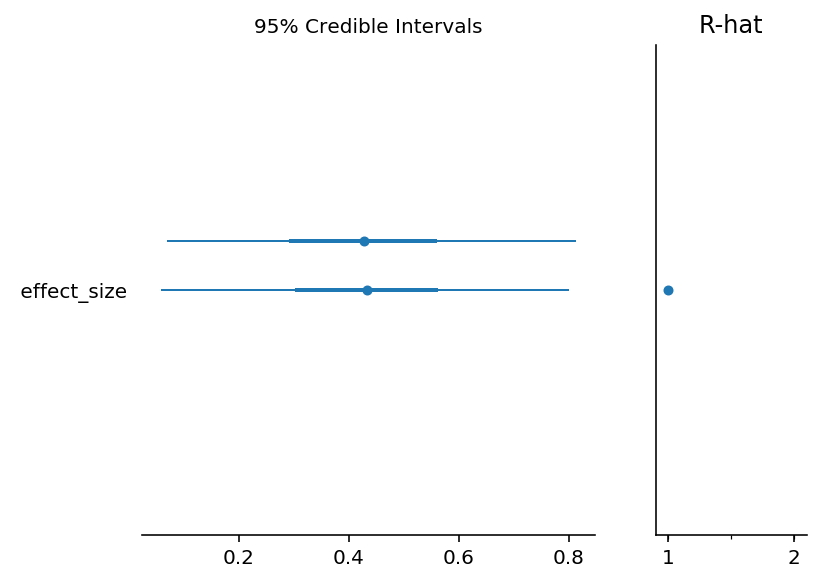

In [11]:
pm.forestplot(kruschke_trace, varnames=['effect_size'])
plt.show()

By computing the posterior distribution over the effect size, we realize that the effect size is most probably of a "medium" size, but that it could also credibly be very large or very small. I would be most comfortable concluding that we need more experimentation to know what is going on.

## Beyond two-group Bayesian estimation

Bayesian estimation has the following advantages:

- We have more assumptions that are explicitly stated in the model, and fewer assumptions that are left implicitly stated.
- We only have to compare posterior distribution beliefs. Multiple hypothesis correction procedures are probably irrelevant.
- Instead of making convoluted claims about 95% confidence intervals (#cite), we instead can state that there is a 95% probability that the true effect size is within the posterior highest density interval, *given the data*.

The Bayesian estimation paper only dealt with two-group comparisons. That said, if we think carefully about Bayesian estimation logic, there should be nothing, in principle, that stops us from including a third, fourth, fifth (and more) groups into the modelling procedure. 

Probabilistic programming allows us to add that third, fourth... up to nth group easily.

To do this, let's add in a 3rd and 4th group, which is drug + a non-pharmaceutical intervention group, and a non-pharmaceutical intervention-only group. Those familiar with experiment design will recognize this as a 2x2 matrix, with ±intervention and ±drug on each axis respectively.

In [42]:
intervention_drug = np.random.randint(low=100, high=110, size=23)
intervention_only = np.random.randint(low=110, high=120, size=14)

In [43]:
data_new = (data
            .append(pd.DataFrame({'IQ': intervention_drug,
                                  'treatment': 'intervention+drug',
                                 })
                   )
            .append(pd.DataFrame({'IQ': intervention_only,
                                  'treatment': 'intervention'
                                 }))
            .label_encode('treatment')
           )

With very compact syntax,  we can express a similar model. The key here is to use the `shape` keyword argument for each distribution object.

In [44]:
with pm.Model() as multigroup_model:
    
    mu = pm.Normal('mu', mu=100, sd=10, shape=(4,))
    sd = pm.HalfCauchy('sd', beta=10, shape=(4,))
    nu = pm.Exponential('nu', 1/29.) + 1
    
    like = pm.StudentT('like', 
                       mu=mu[data_new['treatment_enc'].values],
                       sd=sd[data_new['treatment_enc'].values],
                       nu=nu,
                       observed=data_new['IQ'].values
                      )

Now, we can sample from the posterior.

In [45]:
with multigroup_model:
    trace_mg = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, sd, mu]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:07<00:00, 652.09draws/s]


As usual, the bare minimum that we should do is a sampling convergence check.

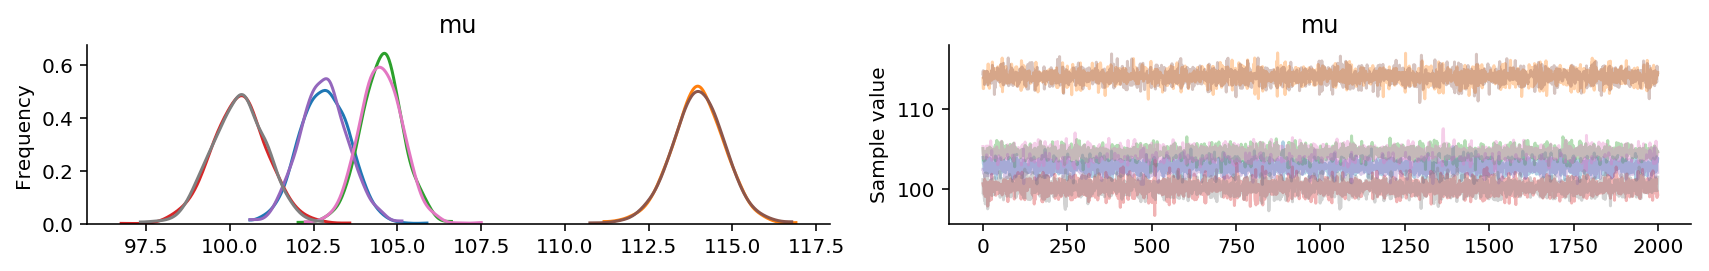

In [50]:
pm.traceplot(trace_mg, varnames=['mu'])
plt.show()

Now, we can examine the posterior distributions on the same scale.

In [47]:
labels = dict(sorted(zip(data_new['treatment_enc'], data_new['treatment']))).values()
labels

dict_values(['drug', 'intervention', 'intervention+drug', 'placebo'])

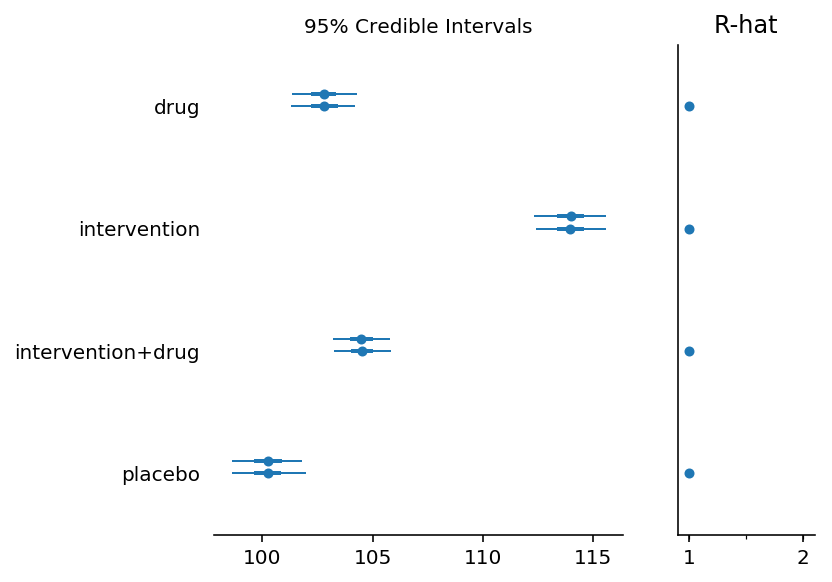

In [51]:
pm.forestplot(trace_mg, varnames=['mu'], ylabels=labels)
plt.show()

For brevity here, we will ignore the computation of effect sizes. 

Comparing all four groups together, we can see very clearly that while the drug might increase IQ relative to a placebo, when compared to an intervention, its effect is less pronounced, and when combined with an intervention, the drug actually reduces the effect of an intervention! 

There are two points to be made here. 

Firstly, this is an example of an A/B/C/D test, where there are four treatments (one of them being the control group). There is no reason to stop at A/B testing.

Secondly, our inferences can be made without requiring the usual ANOVA+post-hoc t-testing. All we have to do is to look at the computed posterior distributions.

## Generalizing

### Beyond t-distributed data

The t-distribution is the generalization of the Normal and Cauchy distributions, and hence is a flexible distribution for modelling purposes. Here, we assumed that our data were t-distributed. However, even this assumption can be changed for a different distribution, with different parameters, and hence different priors placed on those parameters. For example, if our measured variable were count data, then we could change the distribution to a discrete one, such as the poisson or negative binomial, or even zero-inflated versions of them.

### Going hierarchical

While not discussed here, hierarchical models are very easy to implement in PyMC3. Using the example in this notebook, the major change is that instead of specifying a single number for the `mu` and `sd` parameters across all groups, we specify a probability distribution that it is drawn from, with its own "hyper-parameters". More specifically:

```python
with pm.Model() as multigroup_model:
    
    # Group-level hyperparameters
    group_mu = pm.Normal('group_mu', mu=100, sd=10)
    group_sd = pm.Exponential('group_sd', lam=5)
    
    # Individual group parameters
    mu = pm.Normal('mu', mu=group_mu, sd=group_sd, shape=(4,))
    sd = pm.HalfCauchy('sd', beta=group_beta, shape=(4,))
    nu = pm.Exponential('nu', lam=1/29.) + 1
    like = pm.StudentT('like', mu=mu[groups], sd=sd[groups], nu=nu, observed=y_data)
```

## Conclusions

My hope is that this notebook article highlights for you the fact that we need not stop at two group, case/control (A/B) comparisons. With probabilistic programming, we can flexibly and easily specify multi-group comparisons.

For further reading, I would suggest checking out the [Bayesian Analysis Recipes](https://github.com/ericmjl/bayesian-analysis-recipes) repository that I have been building over the years. In the [README](https://github.com/ericmjl/bayesian-analysis-recipes/blob/master/README.md), there are further resources for learning available.